# MÔ HÌNH HÓA DỮ LIỆU

***Đặt ra bài toán*** : Dự đoán giá xe thông qua các thuộc tính khác của xe. Chúng ta cần hiểu điều gì ảnh hưởng đến giá xe và kết hợp càng nhiều thông tin vào mô hình.

Các biến tiềm năng có thể ảnh hưởng đến giá trị xe là:
- Brand, Type, Status, Fuel, Gearbox
- Year, CC, Kilometers, Seating Capacity

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

Đọc dữ liệu và set index là ID

In [2]:
df=pd.read_csv("../data/cars_info_preprocessed.csv")
df=df.set_index("ID")
df.head()

,Name,Price,Brand,Model,Variant,Series,Year,Kilometers,Type,Gearbox,Fuel,Status,CC,Color,Seating Capacity
ID,,,,,,,,,,,,,,,
11530130,2010 Toyota Rukus Build 2 AZE151R,9999,Toyota,Rukus,Build 2,AZE151R,2010,263000,Wagon,Automatic,Unleaded Petrol,Used,2362,Grey,5
12190570,2021 Mercedes-Benz V 250 D Avantgarde MWB 447 ...,117990,Mercedes-Benz,V,250 D Avantgarde MWB,447 MY21,2021,19,Wagon,Automatic,Diesel,New In Stock,2143,Black,7
12321855,2021 Mercedes-Benz Valente 116 CDI MWB RWD 447...,79990,Mercedes-Benz,Valente,116 CDI MWB RWD,447 MY21,2021,24,Wagon,Automatic,Diesel,New In Stock,2143,Black,8
12346971,2010 Mercedes-Benz E250 CDI Avantgarde 207,34990,Mercedes-Benz,E250,CDI Avantgarde,207,2010,120579,Cabriolet,Automatic,Diesel,Used,2143,Black,4
12363884,2016 Holden Cruze CD JH MY16,15990,Holden,Cruze,CD,JH MY16,2016,72506,Sportswagon,Automatic,Unleaded Petrol,Used,1796,White,5


Import một số thư viện trong sklearn để training model

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

Dựa vào kinh nghiệm và tầm nhìn thực tế ta chọn một số cột liên quan đến giá xe.

In [4]:
new_df=df.copy()
new_df=new_df.drop(columns=['Name','Model', 'Series', 'Variant', 'Color'],axis=1)

Chia data ra làm 2 phần:
- Phần 1: chứa các cột có kiểu object
- Phần 2: chứa các cột có kiểu số

In [5]:
cat = []
num = []
for i in new_df.columns:
    if new_df[i].dtypes == 'O':
        cat.append(i)
    else:
        num.append(i)

data_n=new_df[num] 
data_c=new_df[cat]

In [6]:
col=data_c.columns
col

Index(['Brand', 'Type', 'Gearbox', 'Fuel', 'Status'], dtype='object')

Mã hóa các cột có kiểu dữ liệu là object sang kiểu dữ liệu số bằng label encoder. Các số được mã hóa không thể hiện sự so sánh

In [7]:
label_encoders = {}
categorical_columns = data_c.columns 

for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    data_c[column] = label_encoders[column].fit_transform(data_c[column])

Sau khi mã hóa xong ghép 2 phần lại thành 1

In [8]:
frames = [data_c, data_n]
  
data1 = pd.concat(frames,axis=1)
data1.head()

,Brand,Type,Gearbox,Fuel,Status,Price,Year,Kilometers,CC,Seating Capacity
ID,,,,,,,,,,
11530130,56,52,1,5,2,9999,2010,263000,2362,5
12190570,39,52,1,0,1,117990,2021,19,2143,7
12321855,39,52,1,0,1,79990,2021,24,2143,8
12346971,39,4,1,0,2,34990,2010,120579,2143,4
12363884,22,45,1,5,2,15990,2016,72506,1796,5


In [9]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17048 entries, 11530130 to 12852464
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Brand             17048 non-null  int32
 1   Type              17048 non-null  int32
 2   Gearbox           17048 non-null  int32
 3   Fuel              17048 non-null  int32
 4   Status            17048 non-null  int32
 5   Price             17048 non-null  int64
 6   Year              17048 non-null  int64
 7   Kilometers        17048 non-null  int64
 8   CC                17048 non-null  int64
 9   Seating Capacity  17048 non-null  int64
dtypes: int32(5), int64(5)
memory usage: 1.1 MB


X chứa các cột để huấn luyến mô hình, Y chỉ chứa cột tiền. Chia tập dữ liệu làm 2 phần:
- Phần 1 chiếm 70% dòng dữ liệu dùng để training
- Phần 2 chiếm 30% dòng dữ liệu dùng để test.

In [10]:
X = data1.drop(columns="Price")           
y = data1["Price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=0)
print("X Train : ", X_train.shape)
print("X Test  : ", X_test.shape)
print("Y Train : ", y_train.shape)
print("Y Test  : ", y_test.shape)

X Train :  (11933, 9)
X Test  :  (5115, 9)
Y Train :  (11933,)
Y Test  :  (5115,)


Số lượng các đặc trưng để huấn luyện mô hình là: 9

In [11]:
len(X_train.columns)

9

# Áp dụng bài toán với mô hình Multiple Linear Regression

Sử dụng RFE,bây giờ, chúng tôi có 9 đặc trưng dự đoán. Để xây dựng mô hình bằng RFE, chúng tôi cần cho RFE biết chúng tôi muốn có bao nhiêu đặc trưng trong mô hình cuối cùng. Sau đó, nó chạy một thuật toán loại bỏ tính năng. 
Lưu ý rằng số lượng các tính năng được sử dụng trong mô hình là một siêu tham số.

Sử dụng GridSearchCV để tinh chỉnh mô hình Linear Regression với siêu tham số là số lượng các đặc trưng được chọn. Sử dụng 5 fold cross validation để đánh giá trên từng fold của tập train. Sử dụng độ đo là Negative RMSE (càng lớn càng tốt)

In [12]:
# Tạo ra siêu tham số là dãy số lượng đặc trưng được chọn
hyper_params = [{'n_features_to_select': list(range(2, 10))}]

#Tạo ra mô hình
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm)

#Tạo mô hình tinh chỉnh
LR_cv=GridSearchCV(
    estimator=rfe,
    param_grid=hyper_params,
    cv=5,
    scoring='neg_root_mean_squared_error',
    return_train_score=True
)

# Fit với mô hình
LR_cv.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [2, 3, 4, 5, 6, 7, 8, 9]}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

Bảng bên dưới thể hiện kể quả của từng siêu tham số được chọn.

In [13]:
LR_cv_results = pd.DataFrame(LR_cv.cv_results_)
LR_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.013564,0.001018,0.005987,7.001723e-03,2,{'n_features_to_select': 2},-23119.978871,-25353.192137,-29953.539571,-25670.861098,...,-25568.073348,2392.231621,8,-26274.822422,-25755.322764,-24488.194881,-25676.735582,-26135.742168,-25666.163563,630.339753
1,0.010372,0.001492,0.001995,5.436780e-07,3,{'n_features_to_select': 3},-22574.367678,-24661.267381,-29393.218864,-24791.054161,...,-24860.917812,2438.045021,6,-25537.159391,-25049.927939,-23737.861985,-25018.506121,-25467.232378,-24962.137563,647.380279
2,0.011171,0.002130,0.001994,6.306003e-04,4,{'n_features_to_select': 4},-22557.205987,-24684.907811,-29417.078106,-24779.810440,...,-24863.065505,2451.196751,7,-25533.184130,-25031.154383,-23723.410593,-25013.129677,-25460.914587,-24952.358674,650.569380
3,0.008976,0.001092,0.001795,7.463019e-04,5,{'n_features_to_select': 5},-22533.343351,-24676.139306,-29428.286341,-24766.039147,...,-24851.866402,2463.444680,4,-25529.495386,-25029.436515,-23709.953635,-25006.419018,-25456.227672,-24946.306445,654.098066
4,0.010373,0.001197,0.002194,3.991366e-04,6,{'n_features_to_select': 6},-22535.918197,-24678.434549,-29428.181322,-24763.216914,...,-24854.491581,2461.098753,5,-25526.526848,-25026.492855,-23708.893272,-25004.636955,-25451.832797,-24943.676546,653.177112
5,0.007779,0.001163,0.001596,4.883246e-04,7,{'n_features_to_select': 7},-22533.689488,-24679.987907,-27046.658289,-24762.025940,...,-24379.494492,1613.725852,3,-25526.299958,-25025.274303,-21011.879131,-25004.609163,-25449.574759,-24403.527463,1709.150653
6,0.005186,0.000399,0.002194,3.988982e-04,8,{'n_features_to_select': 8},-19829.953277,-21989.288157,-27042.376345,-21839.220883,...,-22227.273494,2543.616738,2,-22932.492582,-22433.689009,-21011.648402,-22470.334670,-22800.549899,-22329.742912,685.989847
7,0.005789,0.001162,0.002192,7.456031e-04,9,{'n_features_to_select': 9},-18985.257867,-21844.386937,-26158.929928,-20942.255029,...,-21485.634040,2548.287711,1,-22160.319990,-21520.410318,-20256.467746,-21714.057461,-22051.069403,-21540.464984,681.780397


Để dễ theo dõi ta sẽ thể hiện quá trình tinh chỉnh bằng biểu đồ

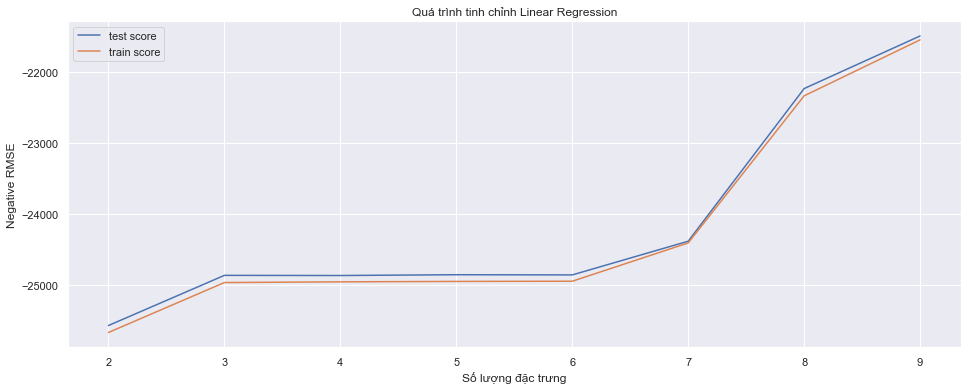

In [14]:
plt.figure(figsize=(16,6))

plt.plot(LR_cv_results["param_n_features_to_select"], LR_cv_results["mean_test_score"])
plt.plot(LR_cv_results["param_n_features_to_select"], LR_cv_results["mean_train_score"])
plt.xlabel('Số lượng đặc trưng')
plt.ylabel('Negative RMSE')
plt.title("Quá trình tinh chỉnh Linear Regression")
plt.legend(['test score', 'train score'], loc='upper left')

Theo biểu đồ ta có thể thấy số lượng đặc trưng lựa chọn tốt nhất với mô hình LN là 9. Chúng ta có thể dùng best_params để tham số tốt nhất

In [15]:
best_params_LR = LR_cv.best_params_
best_params_LR

{'n_features_to_select': 9}

Sau khi tìm ra được tham số tốt nhất cho mô hình LN sẽ fit mô hình LN với tham số đó và dự đoán dưa trên mô hình đã huấn luyện. Sau đó tính RMSE của dự đoán với tập giá trị đúng.

In [16]:
d={}
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm, n_features_to_select=best_params_LR["n_features_to_select"])             
rfe = rfe.fit(X_train, y_train)
y_pred_LR = rfe.predict(X_test)
print(rfe,":",(mean_squared_error(y_test,y_pred_LR))**(1/2))
d.update({str(rfe):(mean_squared_error(y_test,y_pred_LR))**(1/2)})

RFE(estimator=LinearRegression(), n_features_to_select=9) : 24260.93794988934


# Áp dụng bài toán với mô hình KNN Regression

Sử dụng GridSearchCV để tinh chỉnh mô hình KNN Regression với siêu tham số là số lượng các neighbor (chạy từ 4->24). Sử dụng 5 fold cross validation để đánh giá trên từng fold của tập train. Sử dụng độ đo là Negative RMSE (càng lớn càng tốt)

In [17]:
# Tạo ra siêu tham số là số lượng láng giềng
hyper_params = [{'n_neighbors': list(range(4, 25))}]

#Tạo mô hình tinh chỉnh
KNR_cv=GridSearchCV(
    estimator=KNeighborsRegressor(weights='distance'),
    param_grid=hyper_params,
    cv=5,
    scoring='neg_root_mean_squared_error',
    return_train_score=True
)

# Fit với mô hình
KNR_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(weights='distance'),
             param_grid=[{'n_neighbors': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                          15, 16, 17, 18, 19, 20, 21, 22, 23,
                                          24]}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

Bảng bên dưới thể hiện kể quả của từng siêu tham số được chọn.

In [18]:
KNR_cv_results = pd.DataFrame(KNR_cv.cv_results_)
KNR_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.035114,0.013207,0.014559,0.006750,4,{'n_neighbors': 4},-22001.160691,-23108.362967,-26186.630753,-20913.712277,...,-22685.704242,1907.664389,21,-770.740613,-764.394671,-643.301094,-702.774679,-649.449657,-706.132143,54.296766
1,0.024130,0.001174,0.010778,0.000740,5,{'n_neighbors': 5},-21321.122695,-22578.426993,-26091.306344,-20861.095506,...,-22337.791462,1980.574838,20,-768.274946,-764.203930,-640.576557,-702.498604,-647.367399,-704.584287,54.746897
2,0.022543,0.000781,0.012160,0.001600,6,{'n_neighbors': 6},-20938.131616,-22317.456500,-26084.055788,-20816.531416,...,-22154.708544,2054.285857,19,-767.115013,-764.065063,-637.228789,-701.634133,-645.486977,-703.105995,55.632879
3,0.031305,0.015768,0.011767,0.000739,7,{'n_neighbors': 7},-20542.184910,-22229.534418,-25458.421322,-20362.551231,...,-21812.791355,1948.415922,18,-767.114781,-764.041934,-637.225781,-701.649901,-645.477789,-703.102037,55.630291
4,0.023330,0.001354,0.011566,0.000800,8,{'n_neighbors': 8},-20211.752909,-22201.763204,-25402.594746,-20068.027431,...,-21653.743730,2027.748439,17,-767.114781,-764.038065,-637.298352,-701.387103,-645.477789,-703.063218,55.613745
5,0.025266,0.003133,0.014868,0.004143,9,{'n_neighbors': 9},-20101.753239,-21916.980380,-25255.586061,-20022.557617,...,-21523.772196,1990.031465,16,-767.114781,-764.038065,-637.230026,-701.348441,-645.477789,-703.041821,55.630142
6,0.039404,0.023767,0.018949,0.008248,10,{'n_neighbors': 10},-19941.237611,-21724.366259,-25055.405849,-20007.483613,...,-21402.414051,1938.074629,15,-767.114781,-764.038065,-637.224170,-701.348441,-645.477789,-703.040649,55.631528
7,0.022539,0.000797,0.012773,0.000401,11,{'n_neighbors': 11},-19778.508142,-21557.907120,-25068.791827,-20009.800626,...,-21334.339105,1966.339964,14,-767.114781,-764.038065,-637.224170,-701.348441,-645.477789,-703.040649,55.631528
8,0.023133,0.000748,0.012779,0.000406,12,{'n_neighbors': 12},-19707.231765,-21485.325406,-25101.256535,-19977.584554,...,-21298.326980,1996.770639,13,-767.114781,-764.038065,-637.224170,-701.348441,-645.477789,-703.040649,55.631528
9,0.023127,0.000966,0.013578,0.000486,13,{'n_neighbors': 13},-19567.222633,-21475.244081,-25149.091153,-19979.201029,...,-21273.361831,2040.019490,12,-767.114781,-764.038065,-637.224170,-701.348441,-645.477789,-703.040649,55.631528


Để dễ theo dõi ta sẽ thể hiện quá trình tinh chỉnh bằng biểu đồ

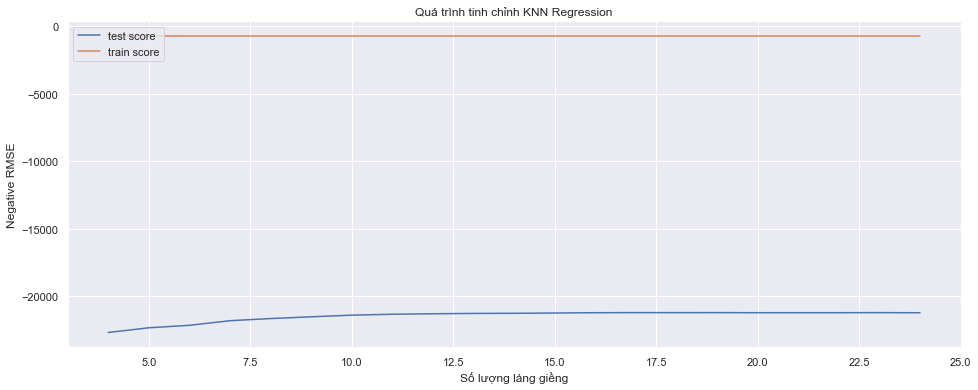

In [19]:
plt.figure(figsize=(16,6))

plt.plot(KNR_cv_results["param_n_neighbors"], KNR_cv_results["mean_test_score"])
plt.plot(KNR_cv_results["param_n_neighbors"], KNR_cv_results["mean_train_score"])
plt.xlabel('Số lượng láng giềng')
plt.ylabel('Negative RMSE')
plt.title("Quá trình tinh chỉnh KNN Regression")
plt.legend(['test score', 'train score'], loc='upper left')

Theo biểu đồ ta có thể thấy số lượng láng giềng tốt nhất với mô hình KNR là 17. Chúng ta có thể dùng best_params để tìm ra tham số tốt nhất.

In [20]:
best_params_KNR = KNR_cv.best_params_
best_params_KNR

{'n_neighbors': 17}

Sau khi tìm ra được tham số tốt nhất cho mô hình KNR sẽ fit mô hình KNR với tham số đó và dự đoán dưa trên mô hình đã huấn luyện. Sau đó tính RMSE của dự đoán với tập giá trị đúng.

In [21]:
KNR = KNeighborsRegressor(n_neighbors=best_params_KNR["n_neighbors"],weights='distance')
KNR.fit(X_train, y_train)
y_pred_KNR = KNR.predict(X_test)
print(KNR,":",(mean_squared_error(y_test,y_pred_KNR))**(1/2))
d.update({str(KNR):(mean_squared_error(y_test,y_pred_KNR))**(1/2)})

KNeighborsRegressor(n_neighbors=17, weights='distance') : 23870.30250386468


# Áp dụng bài toán với mô hình Decision Tree Regression

Sử dụng GridSearchCV để tinh chỉnh mô hình Decision Tree Regression với siêu tham số là độ sâu lớn nhất của cây (chạy từ 2->24). Sử dụng 5 fold cross validation để đánh giá trên từng fold của tập train. Sử dụng độ đo là Negative RMSE (càng lớn càng tốt)

In [22]:
# Tạo ra siêu tham số là độ sâu lớn nhất của cây
hyper_params = [{'max_depth': list(range(2, 25))}]

#Tạo mô hình tinh chỉnh
DTR_cv=GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=0),
    param_grid=hyper_params,
    cv=5,
    scoring='neg_root_mean_squared_error',
    return_train_score=True
)

# Fit với mô hình
DTR_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=0),
             param_grid=[{'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                        14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                        24]}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

Bảng bên dưới thể hiện kể quả của từng siêu tham số được chọn.

In [23]:
DTR_cv_results = pd.DataFrame(DTR_cv.cv_results_)
DTR_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.017131,0.021312,0.001399,0.000491,2,{'max_depth': 2},-21977.328958,-23514.174184,-28025.206159,-22965.976964,...,-23674.737564,2259.097576,23,-24266.138693,-23900.192057,-22691.591229,-24034.723747,-23350.006183,-23648.530382,565.467626
1,0.008583,0.000495,0.001383,0.000508,3,{'max_depth': 3},-20287.069913,-21586.742769,-25863.472632,-21297.087112,...,-21752.015628,2162.884721,21,-22176.667255,-21817.483582,-20715.165227,-21887.293522,-21332.615862,-21585.845090,512.992562
2,0.009981,0.000013,0.001589,0.000483,4,{'max_depth': 4},-23996.189817,-20323.075643,-23650.492192,-22077.937573,...,-21513.428210,2384.057592,20,-19467.111153,-18892.363927,-18031.365669,-19263.951998,-19270.180707,-18984.994691,511.775985
3,0.011582,0.000463,0.001402,0.000470,5,{'max_depth': 5},-32062.413640,-18477.932347,-21297.610920,-16873.031782,...,-21105.982431,5714.604086,19,-16263.973938,-16548.839842,-16163.145879,-16139.095115,-17213.426726,-16465.696300,401.225782
4,0.013166,0.000403,0.001994,0.000018,6,{'max_depth': 6},-31957.401783,-17345.676651,-17928.693551,-26568.660135,...,-21846.278900,6344.996014,22,-14503.425983,-13615.116751,-14208.974254,-14006.645457,-14079.642283,-14082.760946,288.923263
5,0.015006,0.000439,0.001793,0.000401,7,{'max_depth': 7},-15825.654148,-16515.460175,-18429.163401,-15003.895603,...,-16119.506115,1304.011816,10,-12606.994286,-12291.302499,-12239.598956,-12403.593086,-11885.219128,-12285.341591,236.503606
6,0.017148,0.000282,0.001609,0.000486,8,{'max_depth': 8},-31491.225579,-15847.596073,-17853.731095,-13619.690616,...,-18599.167042,6612.480331,16,-11307.312865,-10838.688768,-10967.026946,-11122.840978,-9974.731039,-10842.120120,461.125969
7,0.018759,0.000404,0.001397,0.000499,9,{'max_depth': 9},-31631.455778,-15016.128136,-17685.722714,-13503.961700,...,-18361.161538,6791.666881,14,-10074.928522,-9815.227493,-9881.058940,-9956.083727,-8759.250005,-9697.309738,476.903418
8,0.019818,0.000689,0.001593,0.000475,10,{'max_depth': 10},-17184.377917,-15058.268559,-17177.790823,-13661.090528,...,-15333.575882,1597.021670,6,-8780.063129,-8839.762120,-8853.635863,-8940.541827,-7527.039798,-8588.208547,533.058514
9,0.021465,0.000452,0.001808,0.000405,11,{'max_depth': 11},-32419.029111,-14997.808040,-17097.664420,-13427.344062,...,-18268.645408,7203.213034,11,-7786.709730,-7307.607537,-7833.653853,-7762.214234,-6589.085037,-7455.854078,473.142745


Để dễ theo dõi ta sẽ thể hiện quá trình tinh chỉnh bằng biểu đồ

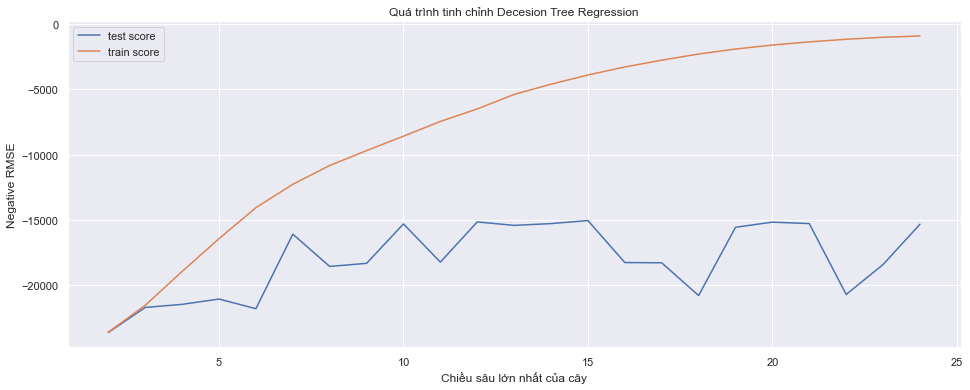

In [24]:
plt.figure(figsize=(16,6))

plt.plot(DTR_cv_results["param_max_depth"], DTR_cv_results["mean_test_score"])
plt.plot(DTR_cv_results["param_max_depth"], DTR_cv_results["mean_train_score"])
plt.xlabel('Chiều sâu lớn nhất của cây')
plt.ylabel('Negative RMSE')
plt.title("Quá trình tinh chỉnh Decesion Tree Regression")
plt.legend(['test score', 'train score'], loc='upper left')

Theo biểu đồ ta có thể thấy chiều sâu lớn nhất của cây tốt nhất với mô hình DTR là 15. Chúng ta có thể dùng best_params để tìm ra tham số tốt nhất.

In [25]:
best_params_DTR = DTR_cv.best_params_
best_params_DTR

{'max_depth': 15}

Sau khi tìm ra được tham số tốt nhất cho mô hình DTR sẽ fit mô hình DTR với tham số đó và dự đoán dưa trên mô hình đã huấn luyện. Sau đó tính RMSE của dự đoán với tập giá trị đúng.

In [26]:
DTR = DecisionTreeRegressor(max_depth=best_params_DTR["max_depth"],random_state=0)
DTR.fit(X_train, y_train)
y_pred_DTR = DTR.predict(X_test)
print(DTR,":",(mean_squared_error(y_test,y_pred_DTR))**(1/2))
d.update({str(DTR):(mean_squared_error(y_test,y_pred_DTR))**(1/2)})

DecisionTreeRegressor(max_depth=15, random_state=0) : 15246.282976358638


# Áp dụng bài toán với mô hình Random Forest Regression

Sử dụng GridSearchCV để tinh chỉnh mô hình Random Forest Regression với siêu tham số là độ sâu lớn nhất của cây (chạy từ 2->24). Sử dụng 5 fold cross validation để đánh giá trên từng fold của tập train. Sử dụng độ đo là Negative RMSE (càng lớn càng tốt)

In [27]:
# Tạo ra siêu tham số là độ sâu lớn nhất của cây
hyper_params = [{'max_depth': list(range(2, 25))}]

#Tạo mô hình tinh chỉnh
RFR_cv=GridSearchCV(
    estimator=RandomForestRegressor(random_state=0),
    param_grid=hyper_params,
    cv=5,
    scoring='neg_root_mean_squared_error',
    return_train_score=True
)

# Fit với mô hình
RFR_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
             param_grid=[{'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                        14, 15, 16, 17, 18, 19, 20, 21, 22, 23,
                                        24]}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

Bảng bên dưới thể hiện kể quả của từng siêu tham số được chọn.

In [28]:
RFR_cv_results = pd.DataFrame(RFR_cv.cv_results_)
RFR_cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.365541,0.007595,0.011968,0.000892,2,{'max_depth': 2},-20093.520982,-22733.993821,-27628.608536,-21449.408578,...,-22453.832920,2749.751645,23,-23035.758041,-23072.432754,-21341.506557,-22130.282984,-22200.723559,-22356.140779,644.919015
1,0.502969,0.029349,0.013166,0.000978,3,{'max_depth': 3},-17819.964764,-20631.336476,-25601.348059,-19259.731920,...,-20301.354611,2824.194898,22,-20398.212715,-20590.924552,-18697.755799,-19847.099074,-20007.752310,-19908.348890,661.066458
2,0.589593,0.003925,0.014375,0.000504,4,{'max_depth': 4},-17228.388447,-19045.983626,-23764.433124,-16794.941428,...,-18566.617427,2784.517315,21,-17382.852856,-17474.793363,-16361.627993,-17080.095584,-17369.031109,-17133.680181,408.110567
3,0.715056,0.012769,0.015997,0.000048,5,{'max_depth': 5},-15493.375193,-17591.552270,-22129.673224,-15718.568583,...,-17134.461200,2668.204261,20,-14963.162212,-15067.309735,-14453.507668,-14944.521977,-15050.898313,-14895.879981,226.276402
4,0.837568,0.065017,0.018781,0.000741,6,{'max_depth': 6},-14479.049179,-16150.953825,-20396.052253,-14380.768793,...,-15795.446648,2448.549150,19,-13116.958366,-12985.271911,-12531.534233,-13000.457670,-12866.976275,-12900.239691,200.644599
5,1.092879,0.104167,0.024723,0.002699,7,{'max_depth': 7},-13831.614544,-15217.372462,-19585.334230,-13716.469487,...,-15037.267512,2398.459051,18,-11826.335572,-11721.738337,-11289.210854,-11687.642452,-11192.318092,-11543.449062,253.193049
6,1.172393,0.106968,0.027244,0.003065,8,{'max_depth': 8},-13499.443230,-14461.387282,-18963.648528,-12956.233295,...,-14419.294633,2387.264561,17,-10611.534542,-10543.571762,-10091.298499,-10547.782679,-9880.710520,-10334.979600,293.604957
7,1.412065,0.100425,0.032312,0.001617,9,{'max_depth': 9},-13270.053716,-13816.133612,-18530.811568,-12545.887545,...,-13971.077047,2388.711119,16,-9524.286333,-9379.478715,-9014.505221,-9467.234876,-8807.058882,-9238.512805,279.350521
8,1.352457,0.108336,0.030731,0.001320,10,{'max_depth': 10},-12819.705130,-13380.699530,-18266.260866,-12306.005186,...,-13622.975454,2416.623996,15,-8578.508006,-8443.288939,-8006.217703,-8525.627649,-7946.309713,-8299.990402,268.481330
9,1.430314,0.014845,0.035896,0.004533,11,{'max_depth': 11},-12538.824257,-12914.728280,-18060.080403,-11788.308372,...,-13258.836012,2489.525636,14,-7744.420682,-7581.769572,-7067.339328,-7726.801045,-7175.323358,-7459.130797,283.593077


Để dễ theo dõi ta sẽ thể hiện quá trình tinh chỉnh bằng biểu đồ

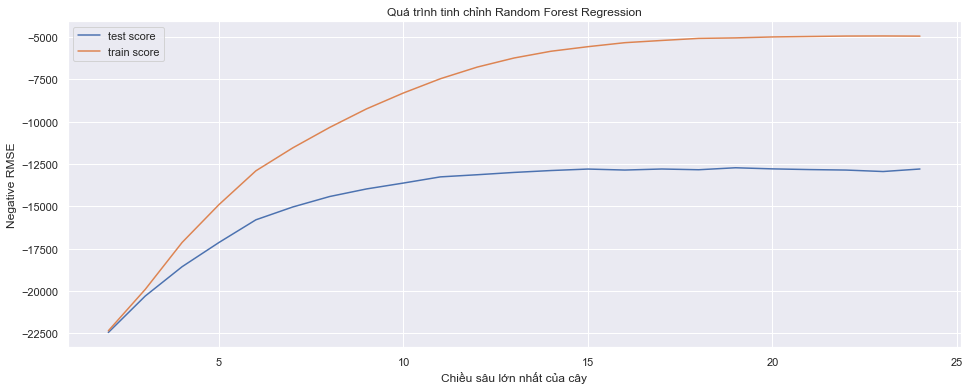

In [29]:
plt.figure(figsize=(16,6))

plt.plot(RFR_cv_results["param_max_depth"], RFR_cv_results["mean_test_score"])
plt.plot(RFR_cv_results["param_max_depth"], RFR_cv_results["mean_train_score"])
plt.xlabel('Chiều sâu lớn nhất của cây')
plt.ylabel('Negative RMSE')
plt.title("Quá trình tinh chỉnh Random Forest Regression")
plt.legend(['test score', 'train score'], loc='upper left')

Theo biểu đồ ta có thể thấy chiều sâu lớn nhất của cây tốt nhất với mô hình RFR là 19. Chúng ta có thể dùng best_params để tìm ra tham số tốt nhất.

In [30]:
best_params_RFR = RFR_cv.best_params_
best_params_RFR

{'max_depth': 19}

Sau khi tìm ra được tham số tốt nhất cho mô hình RFR sẽ fit mô hình RFR với tham số đó và dự đoán dưa trên mô hình đã huấn luyện. Sau đó tính RMSE của dự đoán với tập giá trị đúng.

In [31]:
RFR = RandomForestRegressor(max_depth=best_params_RFR["max_depth"],random_state=0)
RFR.fit(X_train, y_train)
y_pred_RFR = RFR.predict(X_test)
print(RFR,":",(mean_squared_error(y_test,y_pred_RFR))**(1/2))
d.update({str(RFR):(mean_squared_error(y_test,y_pred_RFR))**(1/2)})

RandomForestRegressor(max_depth=19, random_state=0) : 13123.848014626898


# Kết luận

Lưu các kết quả dự đoán của 4 model và kết quả chính xác vào dataframe và file csv

In [32]:
test_dt=pd.DataFrame({'y':y_test,'y_predict_LR':y_pred_LR,'y_predict_KNR':y_pred_KNR,'y_predict_DTR':y_pred_DTR,'y_predict_RFR':y_pred_RFR})
test_dt


,y,y_predict_LR,y_predict_KNR,y_predict_DTR,y_predict_RFR
ID,,,,,
12774801,49790,62494.714215,62020.662438,62291.000000,55080.448333
12688104,60114,55182.158357,44482.459401,53900.000000,54691.150000
12834886,14990,25643.898096,23095.382384,12044.000000,14795.414424
12688835,28990,30216.983090,22741.119730,34584.166667,33281.162973
12747814,26850,28441.351434,19656.415871,38990.000000,29110.430000
...,...,...,...,...,...
12788222,10980,8189.058690,14783.341154,10643.000000,10529.052344
12793059,20990,21154.863459,21590.904043,19548.461538,20475.487487
12849363,28990,36480.016434,36448.858707,28513.250000,28772.658804


In [33]:
test_dt.to_csv("PredictPriceFourModels.csv")

Vẽ biểu đồ so sánh độ RMSE của 4 thuật toán với tham số tốt nhất.

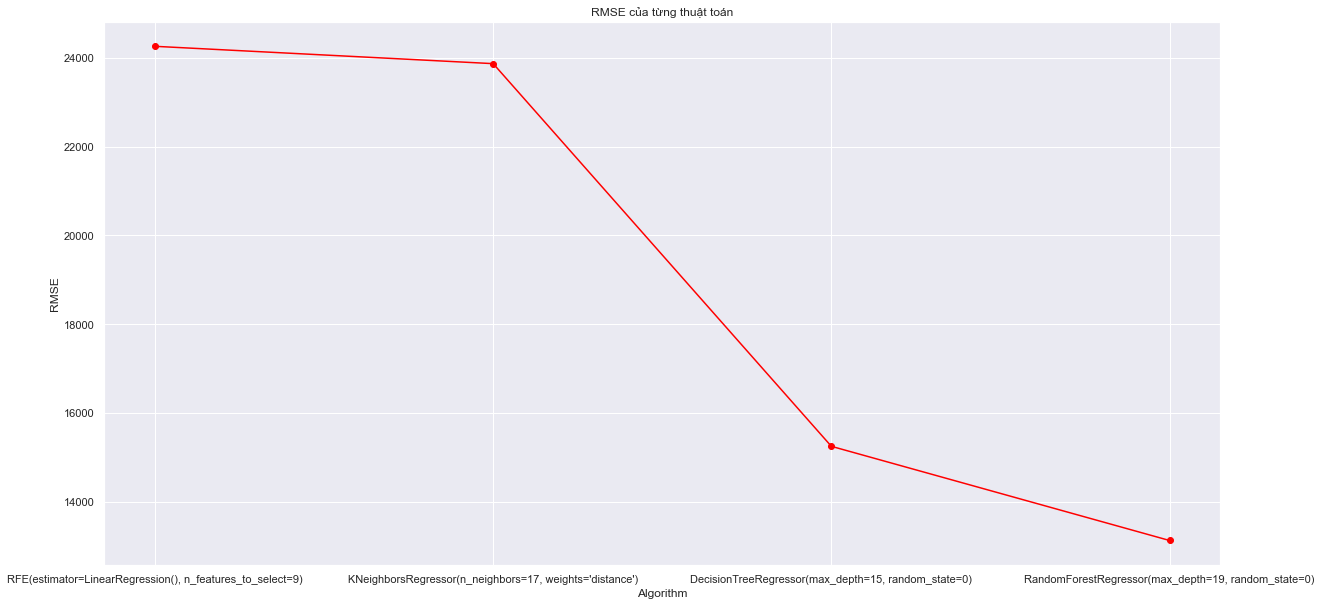

In [34]:
plt.figure(figsize=(20, 10))
plt.title("RMSE của từng thuật toán")
plt.xlabel("Algorithm")
plt.ylabel("RMSE")
plt.plot(d.keys(),d.values(),marker='o',color='red')
plt.show()

Với độ đo RMSE thì RMSE càng nhỏ càng tốt nền => RandomForestRegressor tốt nhất lần lượt tới DecisionTreeRegressor, KNeighborsRegressor và RFE(LinearRegression)